### CIFAR 100 
Object classificaiton tasks


In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
# example of loading the cifar10 dataset
from matplotlib import pyplot


Using TensorFlow backend.


### Declare batch_size, number of epochs, etc.

In [2]:
batch_size = 32
num_classes = 100
epochs = 5
data_augmentation = True
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar100_trained_model.h5'

# load and show the images...

### Real detail about CIFAR 100 dataset

https://web.stanford.edu/~hastie/CASI_files/DATA/cifar-100.html

In [11]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

y_train.shape
y_test.shape

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


(10000, 100)

### Define the architecture of DCNN
The model includes:
1. RelU activation
2. Batch Normalization and 
3. Dropout layer


In [12]:
import keras
from keras.layers.normalization import BatchNormalization


weight_decay = 1e-4

model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
 
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

### Display the DCNN architecture

In [13]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_14 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)       

### Define the optimizer

RMSProp optimization method:

In [7]:
# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Apply the data augmenation and fit the models 

In [8]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test))

Using real-time data augmentation.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/5
1563/1563 [==============================] - 92s 59ms/step - loss: 4.8154 - acc: 0.0672 - val_loss: 3.6265 - val_acc: 0.1598
Epoch 2/5
1563/1563 [==============================] - 89s 57ms/step - loss: 4.0915 - acc: 0.1180 - val_loss: 3.3954 - val_acc: 0.2034
Epoch 3/5
1563/1563 [==============================] - 90s 58ms/step - loss: 3.7903 - acc: 0.1563 - val_loss: 3.1301 - val_acc: 0.2556
Epoch 4/5
1563/1563 [==============================] - 90s 58ms/step - loss: 3.5391 - acc: 0.1899 - val_loss: 2.9957 - val_acc: 0.2739
Epoch 5/5
1563/1563 [==============================] - 90s 57ms/step - loss: 3.3241 - acc: 0.2216 - val_loss: 2.8381 - val_acc: 0.3091


### Save trained weights for the model

In [9]:
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/zahangir/zahangir/DL_class/ece595_dl-master/saved_models/keras_cifar100_trained_model.h5 


### Plot the training and validation accuracy and loss

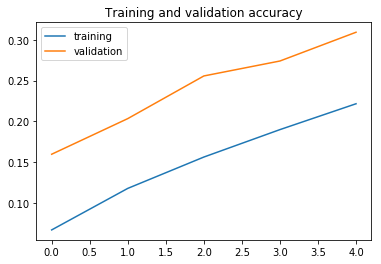

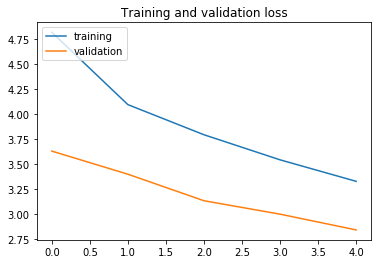

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation accuracy')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.title('Training and validation loss')
plt.show()

### Different optimization methods:

1. SGD
2. ADAM
3. RMSProp ()
4. AdaDElta()


### Stochastic Gradient Descent (SGD)

In [15]:
from keras import optimizers
# initiate RMSprop optimizer
#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### ADADelta example

In [14]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

### ADAM Optimzer

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

### Decreasing LR during the training...

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
model.fit(X_train, Y_train, callbacks=[reduce_lr])

### Model check points

In [ ]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(X_train, Y_train, callbacks=[checkpoint])

### Monitoring and save the models

In [ ]:
callback = [checkpoint,reduce_lr]
model.fit(X_train, Y_train, callbacks=[checkpoint,reduce_lr])